# Project: Creating Mini BERT

In [3]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Checking tf version and gpu
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## 1. Preparing the Tokenizer

In [4]:
import sentencepiece as spm
import os
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000_jp'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # Maximum length of the sentence
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # User-defined token

In [5]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"./{prefix}.model")

True

In [6]:
# Print the list of words excluding seven special tokens
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

In [7]:
vocab_list[:10]

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']

## 2. Data Preprocessing (1) Creating MASK

In [8]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    Create the mask
    :param tokens: tokens
    :param mask_cnt: Number of masked tokens (15% of total tokens)
    :param vocab_list: vocab list (random token)
    :return tokens: masked tokens
    :return mask_idx: masked token's index
    :return mask_label: masked token's original value
    """
    # To mask at the word level, split the indices by spaces
    cand_idx = []  # Index array at the word level
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581" signifies the beginning of a word
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # To create a random mask, shuffle the order (shuffle)
    random.shuffle(cand_idx)

    mask_lms = []  # The masked value
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # Stop if the current count of masked tokens exceeds 15%
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # Skip if the total masked token count, including the upcoming ones, exceeds 15%
            continue
        dice = random.random()  # Probability value between 0 and 1

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # Extract mask_idx and mask_label after sorting mask_lms (using sorted)
    mask_lms = sorted(mask_lms, key=lambda m: m["index"])
    mask_idx = [m["index"] for m in mask_lms]
    mask_label = [m["label"] for m in mask_lms]

    return tokens, mask_idx, mask_label

## 3. Data Preprocessing (2) Creating Next Sentence Prediction (NSP) Pairs

In [9]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    Reducing the lengths of tokens_a and tokens_b with a maximum length of max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: The maximum length of two tokens
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [10]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    Generate pretraining data per document
    """
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # Add data for pretraining on a line-by-line 
        current_length += len(doc[i])  # Number of tokens in the current_chunk
        # If it is the last line or its length is greater than or equal to max_seq
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # Swap with a 50% probability
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # Adjust the length if it exceeds max_seq
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
           #######################################

            # Create tokens and segments
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0

    return instances

## 4. Data Preprocessing (3) Completing the Dataset

In [11]:
# Check the file
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# Check the line count
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [12]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ Creating pretraining data """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # Create a vocab_list excluding seven special characters
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # Exclude the word list that includes 'unknown' during creation 
            vocab_list.append(vocab.id_to_piece(id))

    # Check the line count
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # If the line is empty
                    save_pretrain_instances(out_f, doc)
                    doc = []
                else:  # Tokenize and save to doc if the line is not empty
                    pieces = vocab.encode_as_pieces(line)
                    if len(pieces) == 0:
                        continue
                    doc.append(pieces)
            if 1 < len(doc):  # If there are unprocessed documents at the end
                save_pretrain_instances(out_f, doc)

In [13]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [14]:
# Number of line
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918189

In [15]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    :Load data required for training
    :param vocab: vocabulary
    :param filename: preprocessed json file
    :param n_seq: sequence length (number of sequences)
    :param count: data limit (None for all)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # Limit the number of data
            if count is not None and count <= total:
                break
    
    # When 'np.memmap' is used, it enables processing large-scale data even with limited memory
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)    

In [16]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_31/2481037652.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_31/2481037652.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated i

data load early stop 128000 128000


In [17]:
# Checking first and end
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,   10, 1605, 3599, 1755, 3630,   41, 3644,  830, 3624, 1135,
           52, 3599,   13,   81,   87, 1501, 2247,   25, 3779, 3873, 3667,
         3631, 3813, 3873, 4196, 3636, 3779, 3601,  249, 3725, 1232,   33,
           52, 3599,    6,    6,    6, 6322, 2780,   14, 1509,  168, 3877,
          414,  165, 1697, 4290, 3873, 3703, 3683,  593,   21, 5007,  399,
         1927, 3607,    6,    6,    6,    6,    6,    6,  103, 4313, 4290,
          613, 3638, 3718,   98, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,  489,  376, 3599,    4,    6,    6,  207, 3714,
            6, 1042,  103, 3610, 3686, 3718,    6,    6,   37, 3418,  416,
          810, 3666, 3625,  131, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,  243,    6,    6,    6,  663, 1647, 3682, 3682, 3625,
          203, 3008, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

## 5. Implementing the BERT model

### Define utility functions

In [18]:
def get_pad_mask(tokens, i_pad=0):
    """
    Function for calculating the pad mask
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    Gelu activation function
    :param x: input value
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))


def kernel_initializer(stddev=0.02):
    """
    Create parameter initializer
    :param stddev: Standard deviation of the random variable to be generated
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    Create bias initializer
    """
    return tf.zeros_initializer


class Config(dict):
    """
    Class for using JSON as a configuration format
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        Create Config from a file
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

### Token Embedding

In [19]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        Constructor
        :param config: Config object
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        Create shared weight
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        Run the layer
        :param inputs: input
        :param mode: execution mode
        :return: embedding or linear execution result
        """
        # If the mode is 'embedding', execute an embedding lookup.
        if mode == "embedding":
            return self._embedding(inputs)
        # If the mode is 'linear', execute a linear operation.
        elif mode == "linear":
            return self._linear(inputs)
        # If the mode is other than the specified options, raise an error
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: input
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        Execute the linear
        :param inputs: input
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


### Positional Embedding

In [20]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        Constructor
        :param config: Config object
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        Execute the layer 
        :param inputs: input
        :return embed: position embedding lookup result
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

### Attention

In [21]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        Constructor
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        Execute the layer
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: execution mode
        :return attn_out: attention execution result
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        Constructor
        :param config: Config object
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())


    def call(self, Q, K, V, attn_mask):
        """
        Execute the layer
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: execution mode
        :return attn_out: attention execution result
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m) # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out = tf.transpose(attn_out, [0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out, [batch_size, -1, self.d_model])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

### Position wise Feed Forward Network

In [22]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        Constructor
        :param config: Config object
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        Execute the layer
        :param inputs: inputs
        :return ff_val: feed forward execution result
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

### Encoder Layer

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        Constructor
        :param config: Config object
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        Execute the layer
        :param enc_embed: enc_embed or the output of the previous EncoderLayer
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer execution result
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### BERT

In [24]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        Constructor
        :param config: Config object
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)
        
    def call(self, inputs):
        """
        Execute the layer
        :param inputs: (enc_tokens, segments)
        :return logits: Logits for the next token prediction for 'dec_tokens'
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: input tokens
        :param segments: input segments
        :return embed: embedding result
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

### output layer

In [25]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

### Function for creating a model (model 생성용 함수)

In [26]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

### Define the 'config'

In [27]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

### Check the model training with test data (가짜 데이터로 모델 훈련 체크)

In [28]:
# test train
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 30s 11ms/step - loss: 9.7747 - nsp_loss: 0.7198 - mlm_loss: 9.0549 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 10ms/step - loss: 8.5973 - nsp_loss: 0.6165 - mlm_loss: 7.9808 - nsp_acc: 0.8000 - mlm_acc: 0.0000e+00


## 6. Proceed with pretraining

In [29]:
def lm_loss(y_true, y_pred):
    """
    Loss calculation function
    :param y_true: Ground truth (bs, n_seq)
    :param y_pred: Predicted values (bs, n_seq, n_vocab)
    """
    # Calculate the loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # Mask the parts with pad(0)
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # Increase it 20 times to better learn mlm.

In [30]:
def lm_acc(y_true, y_pred):
    """
    Accuracy calculation function
    :param y_true: Ground truth (bs, n_seq)
    :param y_pred: Predicted values (bs, n_seq, n_vocab)
    """
    # Verification of correctness
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # Mask the parts with pad(0)
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # Compute the accuracy
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [31]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        Constructor
        :param train_steps: total sum of training steps
        :param warmup_steps: warmup steps
        :param max_lr: maximum of learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        Compute the learning rate
        :param step_num: Current step number
        :retrun: Calculated learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

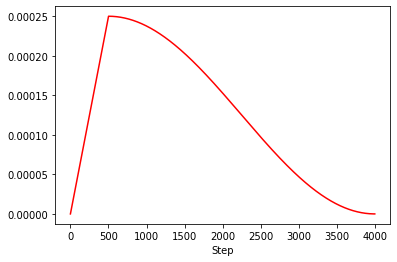

In [32]:
# Compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [33]:
# Create the model
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

In [34]:
epochs = 10
batch_size = 64

# Optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [35]:
# Save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# Train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - 246s 122ms/step - loss: 19.5846 - nsp_loss: 0.6505 - mlm_loss: 18.9341 - nsp_acc: 0.5895 - mlm_lm_acc: 0.1085

Epoch 00001: mlm_lm_acc improved from -inf to 0.10852, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 243s 122ms/step - loss: 17.5079 - nsp_loss: 0.6220 - mlm_loss: 16.8859 - nsp_acc: 0.6181 - mlm_lm_acc: 0.1298

Epoch 00002: mlm_lm_acc improved from 0.10852 to 0.12976, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 243s 122ms/step - loss: 15.9552 - nsp_loss: 0.6156 - mlm_loss: 15.3396 - nsp_acc: 0.6252 - mlm_lm_acc: 0.1493

Epoch 00003: mlm_lm_acc improved from 0.12976 to 0.14933, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 243s 121ms/step - loss: 14.1578 - nsp_loss: 0.6111 - mlm

## 7. Project result

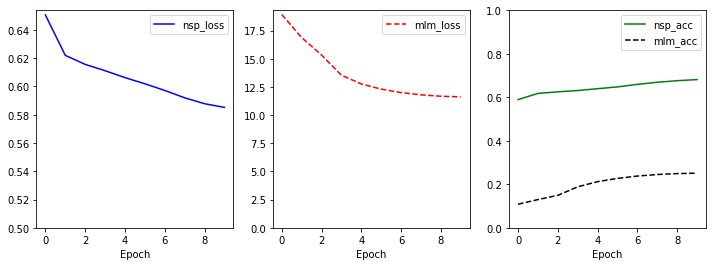

In [36]:
# Training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
# plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.ylim(bottom=0.5)
plt.legend()

plt.subplot(1, 3, 2)
# plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.ylim(bottom=0, top=1)
plt.legend()

plt.show()